<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2022-02-04 19:04:23--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2022-02-04 19:04:24 (86.7 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



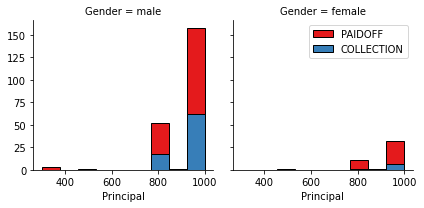

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

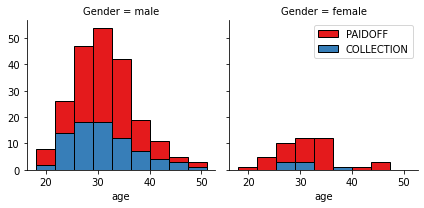

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


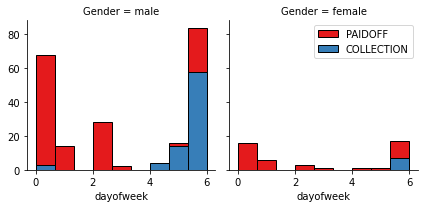

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [17]:
X = Feature
X.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our labels?


In [18]:
y = df['loan_status'].values
print('Shape of y: ', y.shape)
# Y is a numpy array, so we can't 'head' it 
y[0:5]

Shape of y:  (346,)


array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
print('Shape of X: ', X.shape)
# after data standardization, X is an 2 dimensional numpy array
X[0:5]

Shape of X:  (346, 8)


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [20]:
# importing libraries:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics


In [21]:
# splitting 80%/20% into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(X_train[0:5])

(276, 8) (70, 8) (276,) (70,)
[[ 0.51578458  0.92071769 -0.65321055 -0.42056004 -1.20577805 -0.38170062
   1.13639374 -0.86968108]
 [-1.31458942 -0.95911111  2.16570687  2.37778177  0.82934003 -0.38170062
   1.13639374 -0.86968108]
 [ 0.51578458  0.92071769 -0.15575453 -0.42056004 -1.20577805 -0.38170062
  -0.87997669  1.14984679]
 [-1.31458942 -0.95911111 -0.3215732  -0.42056004  0.82934003 -0.38170062
  -0.87997669  1.14984679]
 [ 0.51578458  0.92071769 -0.81902922  2.37778177  0.82934003 -0.38170062
  -0.87997669  1.14984679]]


In [22]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat_knn=neigh.predict(X_test)
    
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat_knn)
    std_acc[n-1]=np.std(yhat_knn==y_test)/np.sqrt(yhat_knn.shape[0])

mean_acc

array([0.65714286, 0.57142857, 0.7       , 0.67142857, 0.71428571,
       0.68571429, 0.75714286, 0.72857143, 0.75714286])

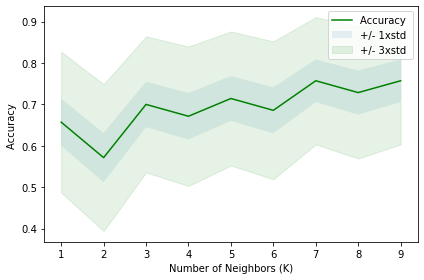

In [23]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [24]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 
print(classification_report(y_test, yhat_knn))

The best accuracy was with 0.7571428571428571 with k= 7
              precision    recall  f1-score   support

  COLLECTION       0.33      0.42      0.37        12
     PAIDOFF       0.87      0.83      0.85        58

    accuracy                           0.76        70
   macro avg       0.60      0.62      0.61        70
weighted avg       0.78      0.76      0.77        70



# Decision Tree


In [25]:
# importing / installing libraries
!pip install pydotplus
from sklearn.tree import DecisionTreeClassifier
from  io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

In [26]:
# define and train decision tree with variable depth
k=10
mean_dec = np.zeros((k-1))
f1_dec = np.zeros((k-1))

for n in range(1,k):
    dectree = DecisionTreeClassifier(criterion="entropy", max_depth = n)
    dectree.fit(X_train, y_train)
    yhat_dec = dectree.predict(X_test)
    mean_dec[n-1] = np.mean(yhat_dec==y_test)
    f1_dec[n-1] = metrics.f1_score(y_test, yhat_dec, average='weighted')

mean_dec

array([0.82857143, 0.82857143, 0.82857143, 0.71428571, 0.8       ,
       0.72857143, 0.74285714, 0.72857143, 0.72857143])

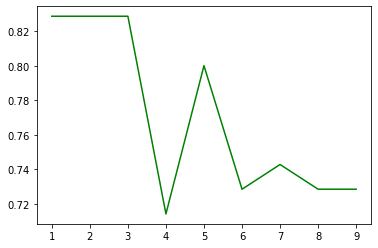

In [27]:
plt.plot(range(1,k),mean_dec,'g')

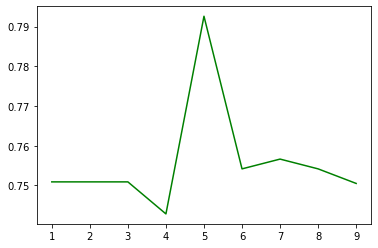

In [28]:
plt.plot(range(1,k),f1_dec,'g')

In [29]:
# best accuracy
print( "The best accuracy was at", mean_dec.max(), "and max_depth of ", mean_dec.argmax()+1)
dectree = DecisionTreeClassifier(criterion="entropy", max_depth = mean_dec.argmax()+1)
dectree.fit(X_train, y_train)
yhat_dec = dectree.predict(X_test)
print(classification_report(y_test, yhat_dec))

The best accuracy was at 0.8285714285714286 and max_depth of  1
              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        12
     PAIDOFF       0.83      1.00      0.91        58

    accuracy                           0.83        70
   macro avg       0.41      0.50      0.45        70
weighted avg       0.69      0.83      0.75        70



/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
# best f1-score
print( "The best f1-score was at", f1_dec.max(), "in max_depth of ", f1_dec.argmax()+1)
dectree = DecisionTreeClassifier(criterion="entropy", max_depth = f1_dec.argmax()+1)
dectree.fit(X_train, y_train)
yhat_dec = dectree.predict(X_test)
print(classification_report(y_test, yhat_dec))

The best f1-score was at 0.7926040061633284 in max_depth of  5
              precision    recall  f1-score   support

  COLLECTION       0.40      0.33      0.36        12
     PAIDOFF       0.87      0.90      0.88        58

    accuracy                           0.80        70
   macro avg       0.63      0.61      0.62        70
weighted avg       0.79      0.80      0.79        70



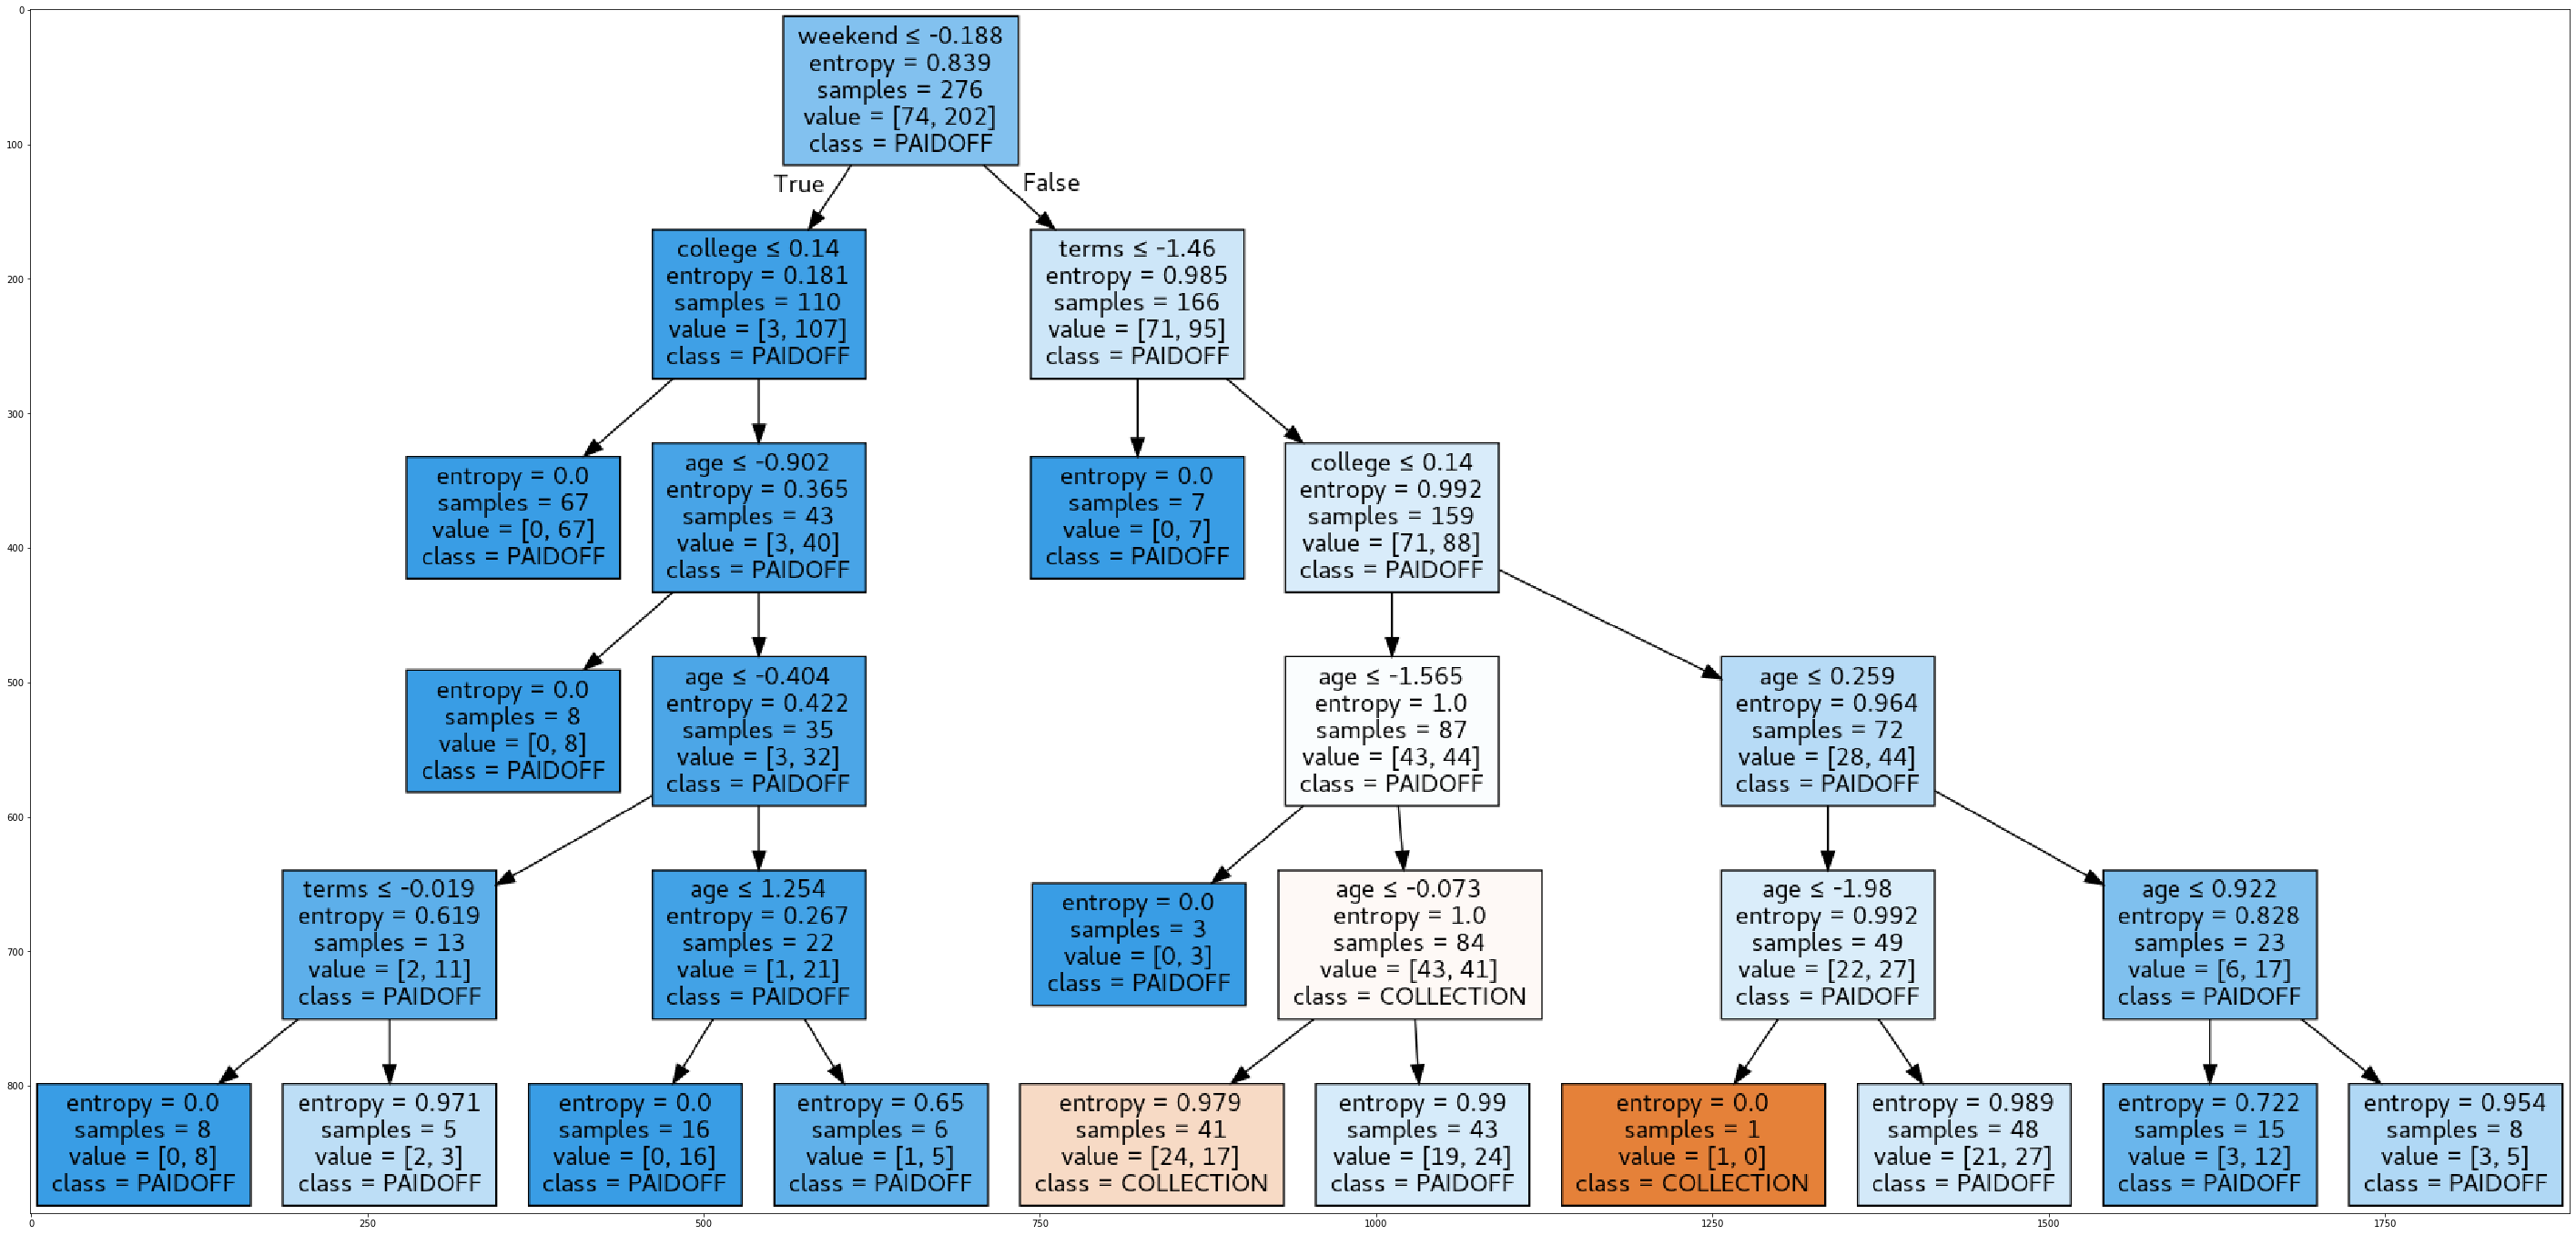

In [31]:
dot_data = StringIO()
filename = "dectree.png"
featureNames = Feature.columns[0:8]
out=tree.export_graphviz(dectree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(50, 50))
plt.imshow(img,interpolation='nearest')

# Support Vector Machine


In [32]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score

# training SVM
svmKernels=['rbf', 'poly', 'linear']
for ker in range(3):
    svmachine = svm.SVC(kernel=svmKernels[ker])
    svmachine.fit(X_train, y_train) 
    yhat_svm = svmachine.predict(X_test)
    
    print('Evaluation of ', svmKernels[ker], 'Suport Vector Machine:')
    print(classification_report(y_test, yhat_svm))
    print()
    


Evaluation of  rbf Suport Vector Machine:
              precision    recall  f1-score   support

  COLLECTION       0.17      0.17      0.17        12
     PAIDOFF       0.83      0.83      0.83        58

    accuracy                           0.71        70
   macro avg       0.50      0.50      0.50        70
weighted avg       0.71      0.71      0.71        70


Evaluation of  poly Suport Vector Machine:
              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        12
     PAIDOFF       0.82      0.97      0.89        58

    accuracy                           0.80        70
   macro avg       0.41      0.48      0.44        70
weighted avg       0.68      0.80      0.74        70


Evaluation of  linear Suport Vector Machine:
              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        12
     PAIDOFF       0.83      1.00      0.91        58

    accuracy                           0.83       

/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We can see that rbf SVM is the only one predicting COLLECTIONs, so we choose it.

In [33]:
svmachine = svm.SVC(kernel='rbf')
svmachine.fit(X_train, y_train) 
yhat_svm = svmachine.predict(X_test)

# Logistic Regression


In [34]:
from sklearn.linear_model import LogisticRegression

lreg = LogisticRegression(C=0.005, solver='liblinear')
lreg.fit(X_train, y_train)
yhat_lreg = lreg.predict(X_test)
yhat_lrprob = lreg.predict_proba(X_test)
print(classification_report(y_test, yhat_lreg))

              precision    recall  f1-score   support

  COLLECTION       0.36      0.33      0.35        12
     PAIDOFF       0.86      0.88      0.87        58

    accuracy                           0.79        70
   macro avg       0.61      0.61      0.61        70
weighted avg       0.78      0.79      0.78        70



# Model Evaluation using Test set


In [35]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:


In [36]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2022-02-04 19:04:46--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2022-02-04 19:04:46 (89.0 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [37]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


<h3>Pre-processing</h3>

In [38]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


<h3>Feature selection</h3>

In [39]:
Feature_eval = test_df[['Principal','terms','age','Gender','weekend']]
Feature_eval = pd.concat([Feature_eval,pd.get_dummies(test_df['education'])], axis=1)
Feature_eval.drop(['Master or Above'], axis = 1,inplace=True)
X_eval = Feature_eval
X_eval.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [40]:
y_eval = test_df['loan_status'].values
print('Shape of y: ', y_eval.shape)
y_eval[0:5]

Shape of y:  (54,)


array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

<h3>Normalization</h3>

In [41]:
X_eval= preprocessing.StandardScaler().fit(X_eval).transform(X_eval)
print('Shape of X: ', X_eval.shape)
# after data standardization, X is an 2 dimensional numpy array
X_eval[0:5]

Shape of X:  (54, 8)


array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

<h3>Classification</h3>

Now we run the models previously trained in the new test set. We DO NOT train them again.

In [42]:
from sklearn.metrics import log_loss

yhat_knn_eval = neigh.predict(X_eval)
yhat_dec_eval = dectree.predict(X_eval)
yhat_svm_eval = svmachine.predict(X_eval)
yhat_lreg_eval = lreg.predict(X_eval)
yhat_lreg_eval_prob = lreg.predict_proba(X_eval) # for logloss 

In [43]:
# KNN Model accuracy
print("KNN's Jaccard is ",jaccard_score(y_eval, yhat_knn_eval, pos_label='PAIDOFF'))
print("KNN's F1 Score is ",f1_score(y_eval, yhat_knn_eval, average='weighted'))

KNN's Jaccard is  0.6730769230769231
KNN's F1 Score is  0.6453810131971051


In [44]:
# Decision Tree Model accuracy
print("Decision Tree's Jaccard is ",jaccard_score(y_eval, yhat_dec_eval, pos_label='PAIDOFF'))
print("Decison Tree's F1 Score is ",f1_score(y_eval, yhat_dec_eval, average='weighted'))

Decision Tree's Jaccard is  0.72
Decison Tree's F1 Score is  0.7144311330357843


In [45]:
# SVM Model accuracy
print("SVM's Jaccard is ",jaccard_score(y_eval, yhat_svm_eval, pos_label='PAIDOFF'))
print("SVM's F1 Score is ",f1_score(y_eval, yhat_svm_eval, average='weighted'))

SVM's Jaccard is  0.72
SVM's F1 Score is  0.7144311330357843


In [46]:
# Log Regression Model accuracy
print("Logistic Regression's Jaccard is ",jaccard_score(y_eval, yhat_lreg_eval, pos_label='PAIDOFF'))
print("Logistic Regression's F1 Score is ",f1_score(y_eval, yhat_lreg_eval, average='weighted'))
print("Logistic Regression's Log Loss is ", log_loss(y_eval, yhat_lreg_eval_prob))

Logistic Regression's Jaccard is  0.7547169811320755
Logistic Regression's F1 Score is  0.6717642373556352
Logistic Regression's Log Loss is  0.6141685694076249


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | 0.67    | 0.64     | NA      |
| Decision Tree      | 0.72    | 0.71     | NA      |
| SVM                | 0.72    | 0.71     | NA      |
| LogisticRegression | 0.75    | 0.67     | 0.61    |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
